In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv('traffic_volume_dataset.csv')

# Convert startDate to datetime
df['startDate'] = pd.to_datetime(df['startDate'], dayfirst=True, errors='coerce')

# Filter records where year >= 2023
df_2023_onwards = df[df['startDate'].dt.year >= 2023]

# Display summary
print(f"Total records from 2023 and onwards: {len(df_2023_onwards)}")
print(df_2023_onwards.head())

# Optionally, save the filtered data
df_2023_onwards.to_csv('traffic_volume_cleaned_2023.csv', index=False)

Total records from 2023 and onwards: 501376
      startDate  siteID    regionName siteReference classWeight  \
9158 2023-01-01       1  03 - Waikato      00200002       Heavy   
9159 2023-01-01       1  03 - Waikato      00200002       Light   
9160 2023-01-01       1  03 - Waikato      00200002       Heavy   
9161 2023-01-01       1  03 - Waikato      00200002       Light   
9162 2023-01-01       2  03 - Waikato      00200033       Heavy   

                                      siteDescription  laneNumber  \
9158                 MANGATAWHIRI - Telemetry Site 74           2   
9159                 MANGATAWHIRI - Telemetry Site 74           2   
9160                 MANGATAWHIRI - Telemetry Site 74           1   
9161                 MANGATAWHIRI - Telemetry Site 74           1   
9162  SH2 Mangatarata VMS Site (950m Sth of SH25 RAB)           1   

      flowDirection  trafficCount  
9158              2         313.0  
9159              2        9451.0  
9160              1         22

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('traffic_volume_cleaned_2023.csv')

# Initial exploration
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (501376, 9)

First few rows:
    startDate  siteID    regionName siteReference classWeight  \
0  2023-01-01       1  03 - Waikato      00200002       Heavy   
1  2023-01-01       1  03 - Waikato      00200002       Light   
2  2023-01-01       1  03 - Waikato      00200002       Heavy   
3  2023-01-01       1  03 - Waikato      00200002       Light   
4  2023-01-01       2  03 - Waikato      00200033       Heavy   

                                   siteDescription  laneNumber  flowDirection  \
0                 MANGATAWHIRI - Telemetry Site 74           2              2   
1                 MANGATAWHIRI - Telemetry Site 74           2              2   
2                 MANGATAWHIRI - Telemetry Site 74           1              1   
3                 MANGATAWHIRI - Telemetry Site 74           1              1   
4  SH2 Mangatarata VMS Site (950m Sth of SH25 RAB)           1              1   

   trafficCount  
0         313.0  
1        9451.0  
2         222.5  
3     

In [25]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values if any
df = df.dropna()  # or use appropriate imputation

# Feature Engineering
# Extract useful information from existing columns
df['year'] = pd.to_datetime(df['startDate']).dt.year
df['month'] = pd.to_datetime(df['startDate']).dt.month
df['day'] = pd.to_datetime(df['startDate']).dt.day
df['day_of_week'] = pd.to_datetime(df['startDate']).dt.dayofweek

# Extract region code from regionName
df['region_code'] = df['regionName'].str.split(' - ').str[0]

# Encode categorical variables
categorical_columns = ['classWeight', 'flowDirection', 'region_code']
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Create binary indicator for heavy vehicles
df['is_heavy'] = (df['classWeight'] == 'Heavy').astype(int)

# Aggregate data by site and date for better analysis
daily_traffic = df.groupby(['siteID', 'startDate']).agg({
    'trafficCount': 'sum',
    'is_heavy': 'mean',  # proportion of heavy vehicles
    'laneNumber': 'max',
    'region_code_encoded': 'first',
    'month': 'first',
    'day_of_week': 'first'
}).reset_index()

print("Daily traffic data shape:", daily_traffic.shape)
print("\nDaily traffic sample:")
print(daily_traffic.head())

Missing values in each column:
startDate          0
siteID             0
regionName         0
siteReference      0
classWeight        0
siteDescription    0
laneNumber         0
flowDirection      0
trafficCount       0
dtype: int64
Daily traffic data shape: (146500, 8)

Daily traffic sample:
   siteID   startDate  trafficCount  is_heavy  laneNumber  \
0       1  2023-01-01       16954.0       0.5           2   
1       1  2023-01-02       22972.0       0.5           2   
2       1  2023-01-03       19600.0       0.5           2   
3       1  2023-01-04       17946.0       0.5           2   
4       1  2023-01-05       13702.0       0.5           2   

   region_code_encoded  month  day_of_week  
0                    2      1            6  
1                    2      1            0  
2                    2      1            1  
3                    2      1            2  
4                    2      1            3  


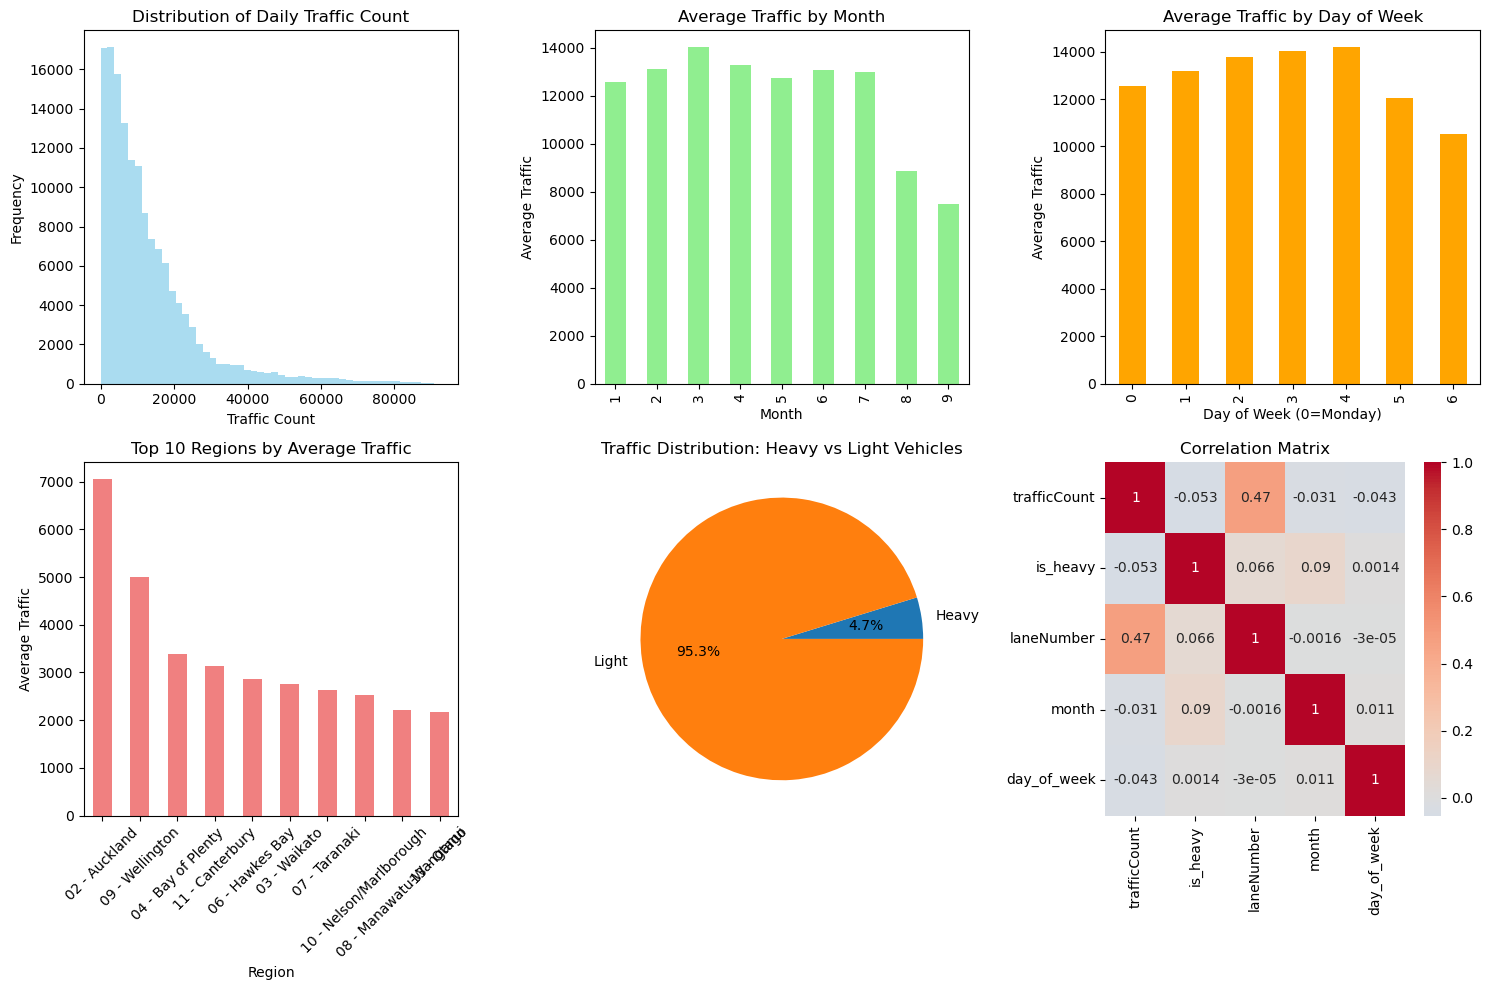

Top 10 sites by total traffic volume:
siteID
3222    16425865.0
3223    16164109.0
2073    15484556.0
2070    15342128.0
2039    15072989.0
2055    14807923.0
2302    14378264.0
2056    14185321.0
1205    13758962.0
2247    12597238.0
Name: trafficCount, dtype: float64


In [9]:
# Visualization 1: Traffic distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(daily_traffic['trafficCount'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Daily Traffic Count')
plt.xlabel('Traffic Count')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
daily_traffic.groupby('month')['trafficCount'].mean().plot(kind='bar', color='lightgreen')
plt.title('Average Traffic by Month')
plt.xlabel('Month')
plt.ylabel('Average Traffic')

plt.subplot(2, 3, 3)
daily_traffic.groupby('day_of_week')['trafficCount'].mean().plot(kind='bar', color='orange')
plt.title('Average Traffic by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Average Traffic')

plt.subplot(2, 3, 4)
region_traffic = df.groupby('regionName')['trafficCount'].mean().sort_values(ascending=False)
region_traffic.head(10).plot(kind='bar', color='lightcoral')
plt.title('Top 10 Regions by Average Traffic')
plt.xlabel('Region')
plt.ylabel('Average Traffic')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
heavy_vs_light = df.groupby('classWeight')['trafficCount'].sum()
plt.pie(heavy_vs_light.values, labels=heavy_vs_light.index, autopct='%1.1f%%')
plt.title('Traffic Distribution: Heavy vs Light Vehicles')

plt.subplot(2, 3, 6)
correlation_matrix = daily_traffic[['trafficCount', 'is_heavy', 'laneNumber', 'month', 'day_of_week']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

plt.tight_layout()
plt.show()

# Top sites by traffic volume
top_sites = df.groupby('siteID')['trafficCount'].sum().sort_values(ascending=False).head(10)
print("Top 10 sites by total traffic volume:")
print(top_sites)

In [27]:
# Prepare features and target variable
feature_columns = ['siteID', 'is_heavy', 'laneNumber', 'region_code_encoded', 'month', 'day_of_week']
X = daily_traffic[feature_columns]
y = daily_traffic['trafficCount']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 117200
Test set size: 29300


In [29]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'KNeighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42)
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Measure training time
    start_time = time.time()
    
    if name in ['Linear Regression', 'KNeighbors Regressor']:
        # Use scaled data for these models
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Use original data for tree-based models
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Training Time (s)': training_time,
        'predictions': y_pred
    }
    
    print(f"{name}:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")

# Compare model performance
comparison_df = pd.DataFrame({
    model: [results[model]['MAE'], results[model]['RMSE'], results[model]['R2'], results[model]['Training Time (s)']] 
    for model in results.keys()
}, index=['MAE', 'RMSE', 'R2 Score', 'Training Time (s)']).T

print("\nModel Comparison:")
print(comparison_df.round(4))


Training Linear Regression...
Linear Regression:
MAE: 7674.69
MSE: 106256495.33
RMSE: 10308.08
R2 Score: 0.3970
Training Time: 0.03 seconds

Training Decision Tree...
Decision Tree:
MAE: 991.27
MSE: 5229697.61
RMSE: 2286.85
R2 Score: 0.9703
Training Time: 0.39 seconds

Training Random Forest...
Random Forest:
MAE: 944.91
MSE: 4628921.55
RMSE: 2151.49
R2 Score: 0.9737
Training Time: 18.47 seconds

Training Gradient Boosting...
Gradient Boosting:
MAE: 4688.74
MSE: 41158718.45
RMSE: 6415.51
R2 Score: 0.7664
Training Time: 5.93 seconds

Training KNeighbors Regressor...
KNeighbors Regressor:
MAE: 2844.80
MSE: 21871901.20
RMSE: 4676.74
R2 Score: 0.8759
Training Time: 0.95 seconds

Training XGBoost Regressor...
XGBoost Regressor:
MAE: 2049.82
MSE: 9920977.84
RMSE: 3149.76
R2 Score: 0.9437
Training Time: 0.26 seconds

Model Comparison:
                            MAE        RMSE  R2 Score  Training Time (s)
Linear Regression     7674.6920  10308.0791    0.3970             0.0341
Decision Tree

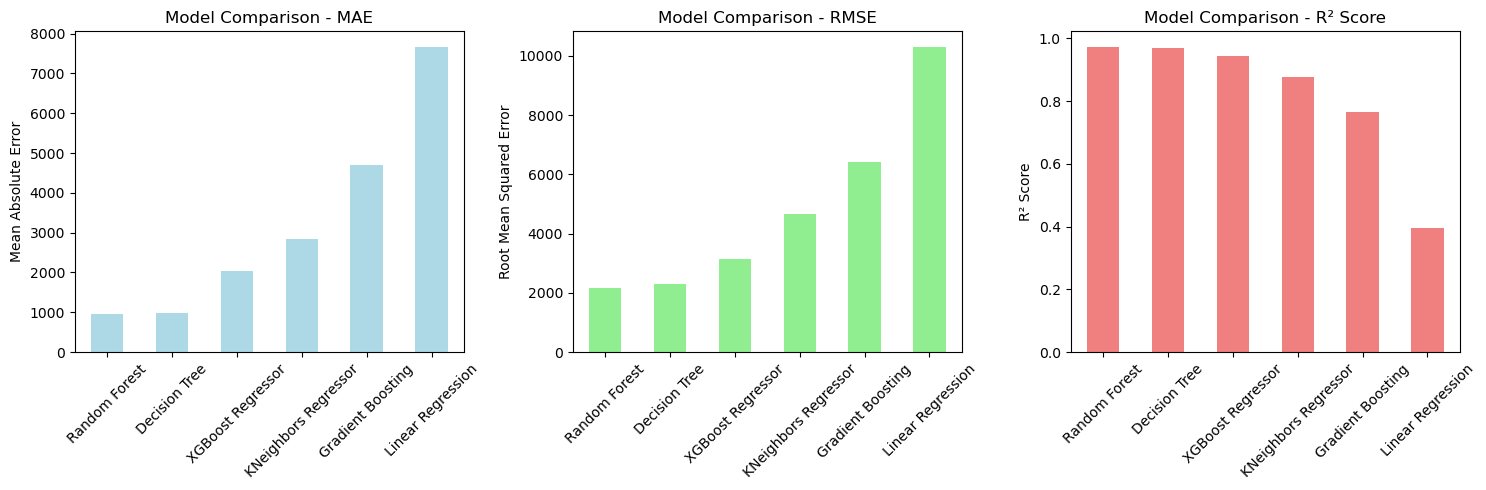

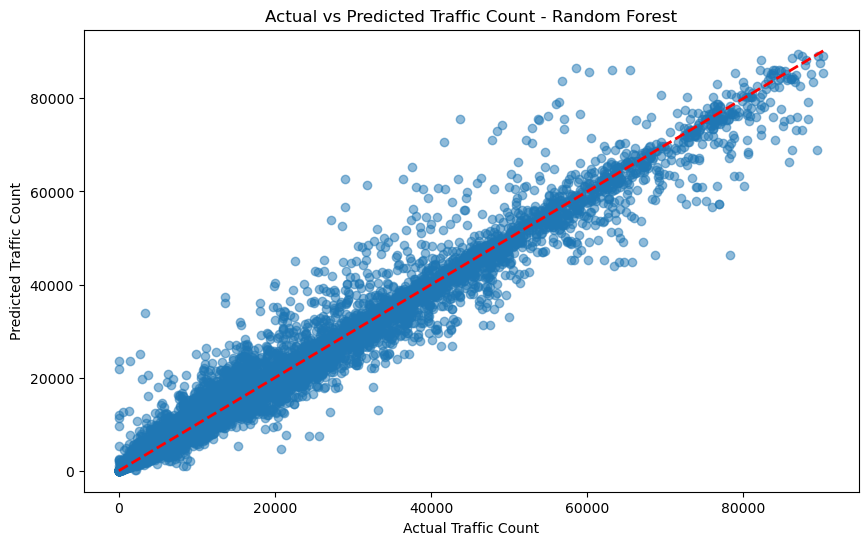

In [33]:
# Plot model performance comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
comparison_df['MAE'].sort_values().plot(kind='bar', color='lightblue')
plt.title('Model Comparison - MAE')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
comparison_df['RMSE'].sort_values().plot(kind='bar', color='lightgreen')
plt.title('Model Comparison - RMSE')
plt.ylabel('Root Mean Squared Error')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
comparison_df['R2 Score'].sort_values(ascending=False).plot(kind='bar', color='lightcoral')
plt.title('Model Comparison - R² Score')
plt.ylabel('R² Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot actual vs predicted for the best model
best_model_name = comparison_df['R2 Score'].idxmax()
best_predictions = results[best_model_name]['predictions']

plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Traffic Count')
plt.ylabel('Predicted Traffic Count')
plt.title(f'Actual vs Predicted Traffic Count - {best_model_name}')
plt.show()

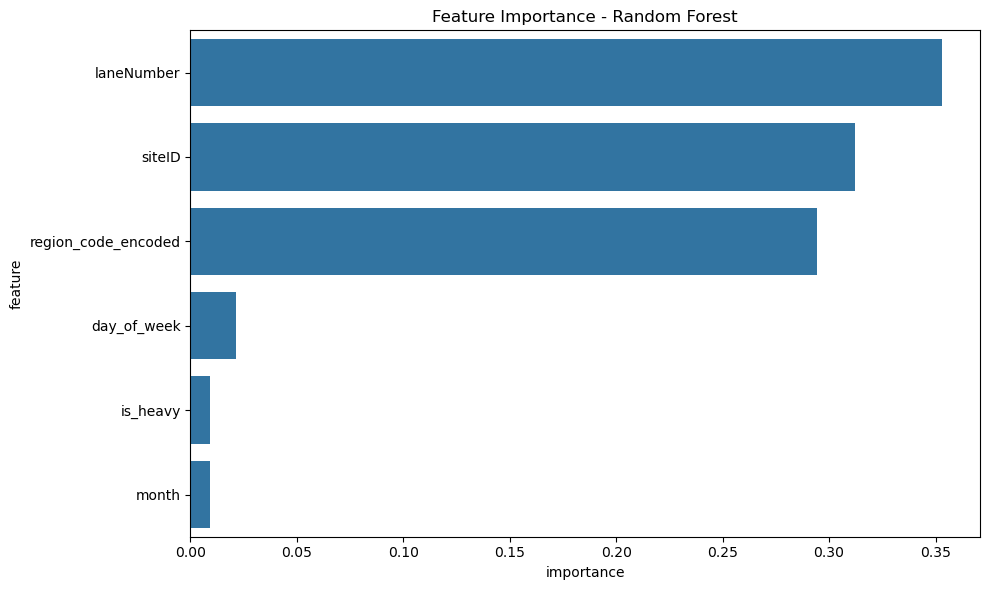

In [17]:
# Get feature importance from the best tree-based model
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost Regressor', 'Decision Tree']:
    if best_model_name == 'Random Forest':
        importances = models[best_model_name].feature_importances_
    elif best_model_name == 'Gradient Boosting':
        importances = models[best_model_name].feature_importances_
    elif best_model_name == 'XGBoost Regressor':
        importances = models[best_model_name].feature_importances_
    else:  # Decision Tree
        importances = models[best_model_name].feature_importances_
    
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance_df, x='importance', y='feature')
    plt.title(f'Feature Importance - {best_model_name}')
    plt.tight_layout()
    plt.show()

In [19]:
# Function to make predictions for new data
def predict_traffic(site_id, is_heavy_ratio, lane_number, region_code, month, day_of_week):
    """
    Predict traffic volume for given parameters
    """
    input_data = pd.DataFrame({
        'siteID': [site_id],
        'is_heavy': [is_heavy_ratio],
        'laneNumber': [lane_number],
        'region_code_encoded': [region_code],
        'month': [month],
        'day_of_week': [day_of_week]
    })
    
    # Use the best model for prediction
    best_model = models[best_model_name]
    
    if best_model_name in ['Linear Regression', 'KNeighbors Regressor']:
        input_scaled = scaler.transform(input_data)
        prediction = best_model.predict(input_scaled)[0]
    else:
        prediction = best_model.predict(input_data)[0]
    
    return prediction

# Example predictions
print("\nExample Predictions:")
print("=" * 50)

# Example 1: Urban area, weekday
pred1 = predict_traffic(site_id=1, is_heavy_ratio=0.1, lane_number=2, 
                       region_code=2, month=6, day_of_week=2)  # Wednesday
print(f"Urban area, weekday prediction: {pred1:.0f} vehicles")

# Example 2: Rural area, weekend
pred2 = predict_traffic(site_id=50, is_heavy_ratio=0.3, lane_number=1, 
                       region_code=8, month=6, day_of_week=6)  # Sunday
print(f"Rural area, weekend prediction: {pred2:.0f} vehicles")

# Example 3: Highway, Monday morning
pred3 = predict_traffic(site_id=100, is_heavy_ratio=0.2, lane_number=4, 
                       region_code=3, month=6, day_of_week=0)  # Monday
print(f"Highway, Monday prediction: {pred3:.0f} vehicles")

# Generate predictions for different scenarios
scenarios = [
    {"desc": "Urban peak hour", "site": 1, "heavy_ratio": 0.05, "lanes": 3, "region": 2, "month": 6, "dow": 0},
    {"desc": "Rural weekend", "site": 80, "heavy_ratio": 0.15, "lanes": 2, "region": 8, "month": 7, "dow": 6},
    {"desc": "Industrial area", "site": 150, "heavy_ratio": 0.4, "lanes": 2, "region": 11, "month": 6, "dow": 2},
]

print("\nScenario-based Predictions:")
print("=" * 50)
for scenario in scenarios:
    pred = predict_traffic(
        scenario["site"], scenario["heavy_ratio"], scenario["lanes"],
        scenario["region"], scenario["month"], scenario["dow"]
    )
    print(f"{scenario['desc']}: {pred:.0f} vehicles")


Example Predictions:
Urban area, weekday prediction: 8724 vehicles
Rural area, weekend prediction: 17600 vehicles
Highway, Monday prediction: 32920 vehicles

Scenario-based Predictions:
Urban peak hour: 11394 vehicles
Rural weekend: 11046 vehicles
Industrial area: 587 vehicles


In [21]:
# Time-based analysis
monthly_trends = daily_traffic.groupby('month').agg({
    'trafficCount': ['mean', 'std', 'count']
}).round(0)

print("\nMonthly Traffic Patterns:")
print(monthly_trends)

# Regional analysis
regional_analysis = daily_traffic.groupby('region_code_encoded').agg({
    'trafficCount': ['mean', 'std', 'count'],
    'is_heavy': 'mean'
}).round(3)

print("\nRegional Traffic Analysis:")
print(regional_analysis)

# Site performance clustering
from sklearn.cluster import KMeans

# Cluster sites based on traffic patterns
site_stats = df.groupby('siteID').agg({
    'trafficCount': ['mean', 'std', 'count'],
    'is_heavy': 'mean',
    'laneNumber': 'max'
}).round(2)

site_stats.columns = ['_'.join(col).strip() for col in site_stats.columns.values]

# Perform clustering
kmeans = KMeans(n_clusters=4, random_state=42)
site_stats['cluster'] = kmeans.fit_predict(site_stats[['trafficCount_mean', 'is_heavy_mean']])

print("\nSite Clusters Summary:")
cluster_summary = site_stats.groupby('cluster').agg({
    'trafficCount_mean': ['mean', 'std'],
    'is_heavy_mean': 'mean',
    'trafficCount_count': 'count'
}).round(2)
print(cluster_summary)


Monthly Traffic Patterns:
      trafficCount                
              mean      std  count
month                             
1          12582.0  12434.0  20984
2          13130.0  13392.0  18829
3          14033.0  14282.0  20313
4          13291.0  13515.0  18747
5          12753.0  13319.0  21596
6          13081.0  13584.0  19631
7          12992.0  13741.0  18821
8           8870.0   8187.0   7339
9           7472.0   5802.0    240

Regional Traffic Analysis:
                    trafficCount                   is_heavy
                            mean        std  count     mean
region_code_encoded                                        
0                       7389.273   7619.602   4035    0.500
1                      23254.436  20030.717  33605    0.350
2                       9435.608   6859.496   3475    0.361
3                      14416.820   8878.299   3215    0.420
4                       4621.816   1923.771    993    0.446
5                       8926.519   7076.920  

  File "C:\Users\Lenovo\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Lenovo\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
